# Deep Learning 101
Deep learning is one of the most impactful technologies of the past few years and will continue to be of huge importance for our technological advancement. It's therefore important to have a good understanding of the basics before tackling more complex problems with existing libraries like Tensorflow or Pytorch. However, a lot of people still make wrong assumptions about what deep learning is or just see it as some kind of black magic. To help remedy this I wrote a series of blogs together with this repository. This notebook follows along with the blogs, explaining step by step what is going on.

The blogs on medium:
- Part 1 discusses the basics and the forward pass:  TBD
- Part 2 discusses backpropagation:  TBD
- Part 3 goes over several techniques to improve the learning ability of a network:  TBD

This notebook handles the contents of the second blog.

In [1]:
# To make our lives a bit easier, I'll be using numpy 
import numpy as np

# Later on we will also be creating some plots to visualize our results.
import matplotlib.pyplot as plt

## Recap from the previous blog

In [2]:
class Dense:
    def __init__(self, input_size, output_size):
        """Constructor of a single fully connected layer

        Args:
            input_size (int): number of inputs to this layer
            output_size (int): number of neurons in this layer, which is equivalent to the number of outputs
        """
        # Create our matrix with weights and biases for the layer
        self.weights = np.random.randn(output_size, input_size)
        self.biases = np.zeros(output_size)
        
    def forward(self, inputs):
        """Forward pass of the layer"""
        self.inputs = inputs
        self.output = np.dot(self.weights, self.inputs) + self.biases
        return self.output

    
class ReLU:
    def forward(self, inputs):
        """Forward pass of the activation function"""
        self.inputs = inputs
        self.output = np.maximum(0, self.inputs)
        return self.output

## Backpropagation
Backpropagation comes down to computing the gradient of the error for each weight and bias, propagating this backwards through the network. To do so we can make use of the chain rule. I won't dive into the mathematics as others have explained this much better than I can. In the end it boils down to the following:

- the gradients (dZ) are initialized with the error * derivative of the last activation(input of last activation)
- these are the gradients for the last layer
- the gradients are passed through the last layer dA = dZ dot W^T
- and through the next activation: dZ = dA * derivative of the activation(input of this activation)
- these are the gradients for the next layer
- repeat until you have the gradients for each layer

Then we can update the weights and biases of these layers with their gradients:
- W := W - lr * (dZ^T dot layer inputs)
- B := B - lr * mean(dZ)

And that is basically it. Let's implement this in our code.

In [3]:
class Dense:
    def __init__(self, input_size, output_size):
        """Constructor of a single fully connected layer

        Args:
            input_size (int): number of inputs to this layer
            output_size (int): number of neurons in this layer, which is equivalent to the number of outputs
        """
        self.input_size = input_size
        self.output_size = output_size
        
        # Create our matrix with weights and biases for the layer
        self.weights = np.random.randn(output_size, input_size)
        self.biases = np.zeros(output_size)
        
    def forward(self, inputs):
        """Forward pass of the layer"""
        self.inputs = inputs
        self.output = np.dot(self.inputs, self.weights.T) + self.biases
        return self.output
    
    def update_gradients(self, gradients):
        """Update the gradients of the layer"""
        self.gradients = gradients
        
    def optimize(self, learning_rate):
        """Optimize the weights by taking a step in the direction of the gradients"""
        self.weights -= learning_rate * (np.dot(self.gradients.T, self.inputs) / self.input_size)
        self.biases -= learning_rate * np.mean(self.gradients, axis=0)

We need some overarching structure to pass along the gradients from layer to layer. We can do this with a simple class representing a neural network:

In [66]:
class Network:
    def __init__(self, layers, activations, learning_rate):
        """Constructor of a neural network
        
        Args:
            layers (list): list of integers, each integer corresponds to the number of neurons in a layer
            activations (list): list of activation functions, each activation function corresponds to a layer
        """
        self.layers = layers
        self.activations = activations
        self.learning_rate = learning_rate
        
    def forward(self, inputs):
        """Forward pass of the network"""
        self.inputs = inputs
        for i in range(len(self.layers)):
            self.inputs = self.activations[i].forward(self.layers[i].forward(self.inputs))
        return self.inputs
    
    def backward(self, loss):
        """Backward pass of the network"""
        self.gradients = loss * self.activations[-1].derivative_activation()   # dZ = dA * act'(Z)
        #self.gradients = loss
        self.layers[-1].update_gradients(self.gradients)
        
        for i in range(len(self.layers) - 2, -1, -1):
            self.gradients = np.dot(self.gradients, self.layers[i+1].weights)  # dA = dZ dot W
            self.gradients = self.gradients * self.activations[i].derivative_activation() # dZ = dA * act'(Z)
            self.layers[i].update_gradients(self.gradients)             

    def optimize(self):
        """Optimize the network"""
        for layer in self.layers:
            layer.optimize(self.learning_rate)

The final thing we need is the derivative of the activation function. In the previous blog we only had the ReLU, let's add some others here as well.

In [5]:
class ReLU:
    def forward(self, inputs):
        """Forward pass of the activation function"""
        self.inputs = inputs
        self.output = np.maximum(0, self.inputs)
        return self.output
    
    def derivative_activation(self):
        """Backward pass of the activation function"""
        return self.inputs > 0
    
class Sigmoid:
    def forward(self, inputs):
        """Forward pass of the activation function"""
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-self.inputs))
        return self.output
    
    def derivative_activation(self):
        """Backward pass of the activation function"""
        return self.output * (1 - self.output)
    
class Tanh:
    def forward(self, inputs):
        """Forward pass of the activation function"""
        self.inputs = inputs
        self.output = np.tanh(self.inputs)
        return self.output
    
    def derivative_activation(self):
        """Backward pass of the activation function"""
        return 1 - self.output ** 2

## Testing things out

Now that we have all the basics we can put our neural network to the test. Let's say we want to model a random nonlinear function, for example this:

In [67]:
def function_to_model(input):
    if input < -50:
        return 0
    elif input < 0:
        return (input + 50) / 50
    elif input < 50:
        return 1
    else:
        return (50 - input) / 50 + 1

In [68]:
x_train = np.linspace(-100, 100, 2000).reshape(-1, 1)
y_train = np.fromiter((function_to_model(x) for x in x_train), dtype=x_train.dtype).reshape(-1, 1)

x_test = np.linspace(-95, 95, 200).reshape(-1, 1)
y_test = np.fromiter((function_to_model(x) for x in x_test), dtype=x_test.dtype).reshape(-1, 1)

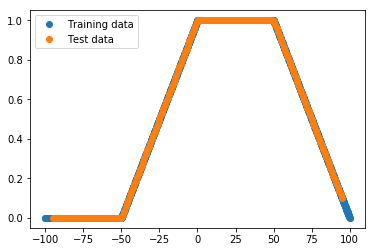

In [69]:
plt.plot(x_train, y_train, 'o', label='Training data')
plt.plot(x_test, y_test, 'o', label='Test data')
plt.legend()

This is the dataset we want to model. Now to build a neural network and train it on this data. To check our progress I will be using the root mean square error (rmse).

In [70]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

0.281971903962121


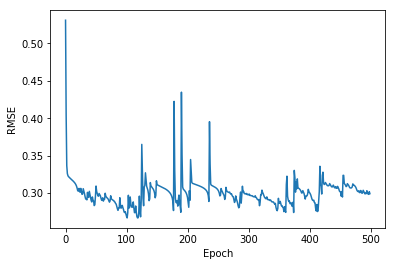

In [71]:
network = Network([Dense(1, 32), Dense(32, 32), Dense(32, 16), Dense(16, 16), Dense(16, 1)], [Sigmoid(), Sigmoid(), Sigmoid(), Sigmoid(), Tanh()], 0.001)

losses = []

for epoch in range(500):
    y_pred = network.forward(x_train)
    loss = rmse(y_pred, y_train)
    losses.append(loss)
    network.backward(y_pred - y_train)
    network.optimize()

plt.plot(losses)
plt.ylabel('RMSE')
plt.xlabel('Epoch')

# Test the network
y_hat = network.forward(x_test)
loss = rmse(y_hat, y_test)
print(loss)

Finally, let's check the result:

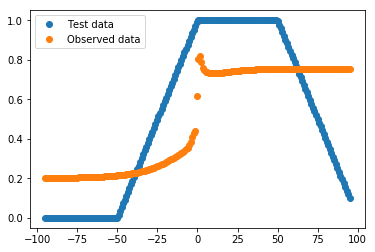

In [72]:
plt.plot(x_test, y_test, 'o', label='Test data')
plt.plot(x_test, y_hat, 'o', label='Observed data')
plt.legend()

We see the model improve, but the loss is very jittery. What happens is that our learning rate is too high, meaning that it jumps back and forth over the actual minimum that we want to reach. To solve this we have to decrease our learning rate, but doing so will make our model learn more slowly, so we need more epochs:

0.19301231328332583


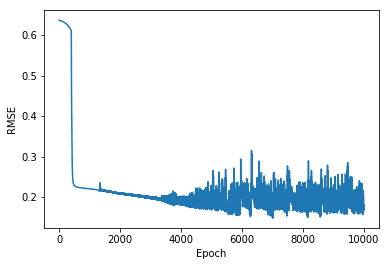

In [80]:
network = Network([Dense(1, 32), Dense(32, 32), Dense(32, 16), Dense(16, 16), Dense(16, 1)], [Sigmoid(), Sigmoid(), Sigmoid(), Sigmoid(), Tanh()], 0.0001)

losses = []

for epoch in range(10000):
    y_pred = network.forward(x_train)
    loss = rmse(y_pred, y_train)
    losses.append(loss)
    network.backward(y_pred - y_train)
    network.optimize()

plt.plot(losses)
plt.ylabel('RMSE')
plt.xlabel('Epoch')

# Test the network
y_hat = network.forward(x_test)
loss = rmse(y_hat, y_test)
print(loss)

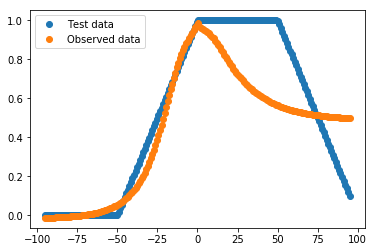

In [81]:
plt.plot(x_test, y_test, 'o', label='Test data')
plt.plot(x_test, y_hat, 'o', label='Observed data')
plt.legend()

This is already better, but still some jitter.

0.06478649320874534


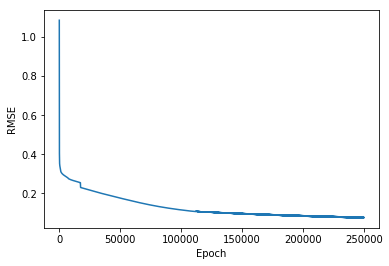

In [90]:
network = Network([Dense(1, 32), Dense(32, 32), Dense(32, 16), Dense(16, 16), Dense(16, 1)], [Sigmoid(), Sigmoid(), Sigmoid(), Sigmoid(), Tanh()], 0.00001)

losses = []

for epoch in range(250000):
    y_pred = network.forward(x_train)
    loss = rmse(y_pred, y_train)
    losses.append(loss)
    network.backward(y_pred - y_train)
    network.optimize()

plt.plot(losses)
plt.ylabel('RMSE')
plt.xlabel('Epoch')

# Test the network
y_hat = network.forward(x_test)
loss = rmse(y_hat, y_test)
print(loss)

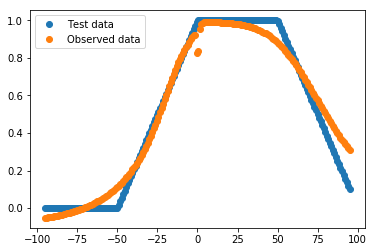

In [91]:
plt.plot(x_test, y_test, 'o', label='Test data')
plt.plot(x_test, y_hat, 'o', label='Observed data')
plt.legend()

And that's it, the neural network learned to model our function. It's not perfect, but with more training we can improve it further. Now one problem that we see is that this is really slow, but if we try to speed the training up we get a very unstable loss per epoch as we jump over the optimum. There are some techniques to deal with this. Let's have a look at some of these modifications in the next notebook.